## A/B testing for a Video Game

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import os
os.chdir('C:/Users/pooja/Desktop/DR/Kaggle/AB Testing/')

This project is based on a mini project from Datacamp.

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment.<br>
It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.<br>
It also features singing cats.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress.<br>In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.
<br>
But where should the gates be placed? Initially the first gate was placed at level 30.<br> In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40.<br> In particular, we will look at the impact on player retention.

### Read the data

In [9]:
org=pd.read_csv('cookie_cats.csv')
print(org.shape)
org.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first week after installation
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?
- When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

### Missing value analysis

In [18]:
org.info()
#No missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Exploratory Data Analysis

In [19]:
org.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


__The number of players in both the groups is approximately the same__

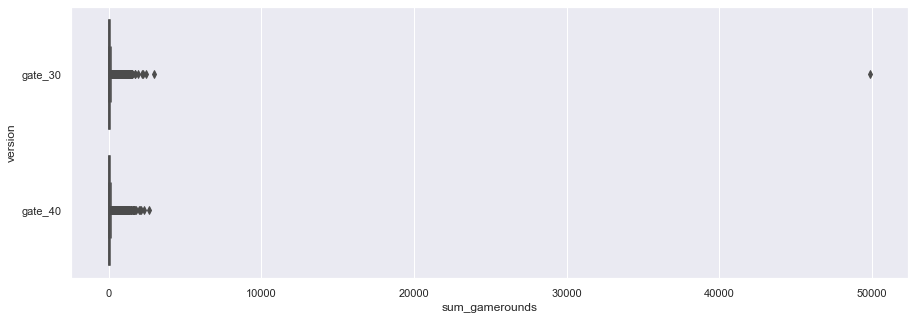

In [26]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(x=org.sum_gamerounds, y=org.version);

__There is an outlier who played 50,000 rounds within first week of installation!__

In [27]:
org.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

50% of users played less than 16 rounds of the game a weke after game installation.
75% played less than 51 rounds

In [40]:
df=org.groupby('sum_gamerounds')['userid'].count().reset_index()
df['cum_sum']=df.userid.cumsum()
df

,sum_gamerounds,userid,cum_sum
0,0,3994,3994
1,1,5538,9532
2,2,4606,14138
3,3,3958,18096
4,4,3629,21725
...,...,...,...
937,2294,1,90185
938,2438,1,90186
939,2640,1,90187
940,2961,1,90188


__Nearly 4000 users did not play a single game after installation__<br>
__More than 14,000 users played less than 3 rounds__

__From the above analysis, we conclude that even though some users install the game, they never play it.__<br>
__There can be several reasons for this behaviour:__<br>
- __The users did not like the interface__<br>
- __They found it too easy__<br>
- __The game did not match their expectations__

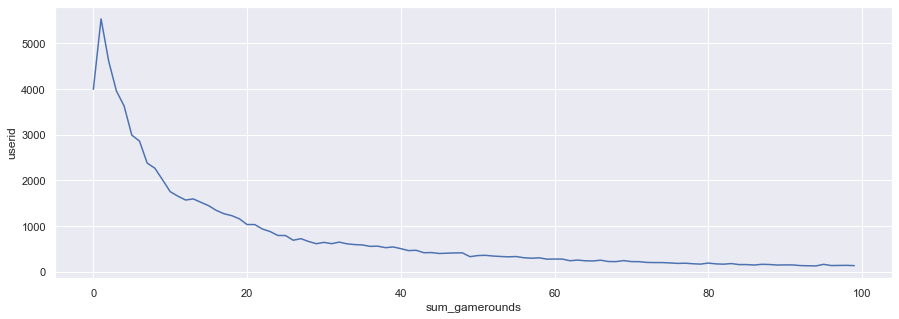

In [46]:
sns.lineplot(df[:100].sum_gamerounds,df.userid);

__The distribution is highly skewed to the right. From the above plot, we observe that a sizeable number of users, about 300, continued with the game after 60 rounds.__

__A common metric in the video gaming industry for how fun and engaging a game is 1-day retention:__<br>
__the percentage of players that comes back and plays the game one day after they have installed it.__<br>
__The higher 1-day retention is, the easier it is to retain players and build a large player base.__

In [60]:
print("The average 1 day retention is "'{:.2f}%'.format(org.retention_1.sum()*100/org.retention_1.count()))

The average 1 day retention is 44.52%


__44.52% users play the game after installation. This number is our benchmark for user retention.__

In [61]:
org.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

__User retention decreased by 0.6% when the gate was moved from level 30 to 40.__<br>
__This number may not sound alarming for a small dataset.__<br>
__However, minor change can have large business impact.__<br>
__We further test this impact by bootstrapping the samples.__

In [96]:
boot_1_day=[]

for i in range(500):
    boot_1_mean=org.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
    boot_1_day.append(boot_1_mean)

In [97]:
boot_1_day=pd.DataFrame(boot_1_day)

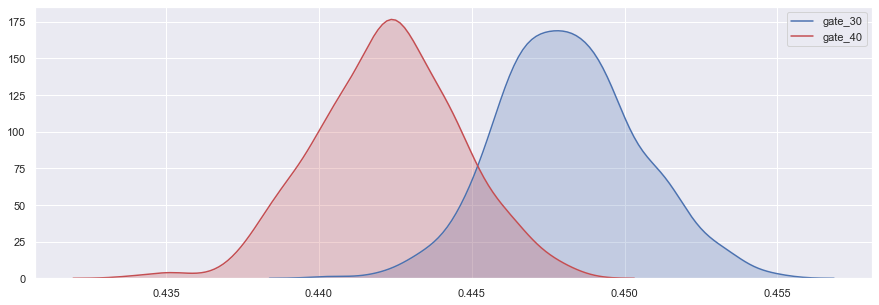

In [98]:
p1=sns.kdeplot(boot_1_day['gate_30'], shade=True, color="b")
p1=sns.kdeplot(boot_1_day['gate_40'], shade=True, color="r")

__The above plot is a representation of uncertainity for the gates placed at levels 30 and 40.__

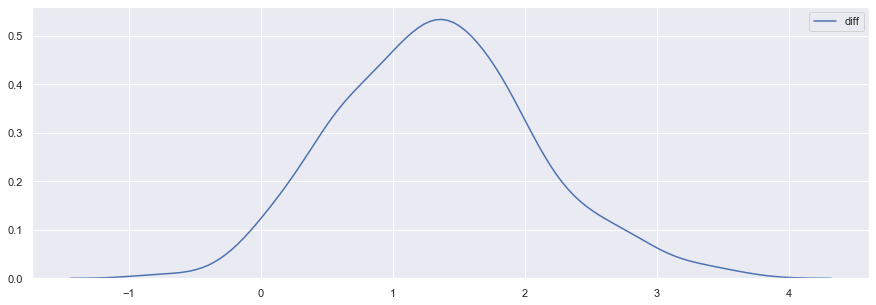

In [99]:
boot_1_day['diff']=(boot_1_day['gate_30']-boot_1_day['gate_40'])/boot_1_day['gate_40']*100

sns.kdeplot(boot_1_day['diff']);

__The difference in retention is most likely between 1%-2%.__<br>
__The distribution favours retention of gate at level 30 since ~97% falls above 0%.__ (68+13.5+2.5+13.5)

In [79]:
print("The average 7 day retention is "'{:.2f}%'.format(org.retention_7.sum()*100/org.retention_7.count()))

The average 7 day retention is 18.61%


In [ ]:
18.61% users play the game a week after installation. This number less than 1 day retention by more than 25%.

In [80]:
org.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

__7 day user retention decreased by 0.8% when the gate was moved from level 30 to 40.__<br>
__This number may not sound alarming for a small dataset.__<br>
__However, minor change can have large business impact.__<br>
__We further test this impact by bootstrapping the samples.__

In [93]:
boot_7_day=[]

for i in range(500):
    boot_7_mean=org.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7_day.append(boot_7_mean)

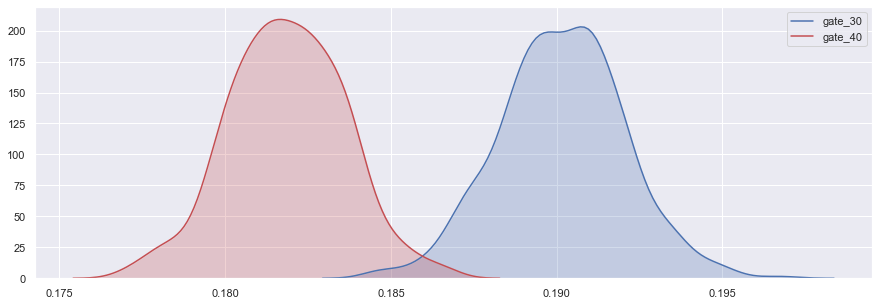

In [94]:
boot_7_day=pd.DataFrame(boot_7_day)
p1=sns.kdeplot(boot_7_day['gate_30'], shade=True, color="b")
p1=sns.kdeplot(boot_7_day['gate_40'], shade=True, color="r")

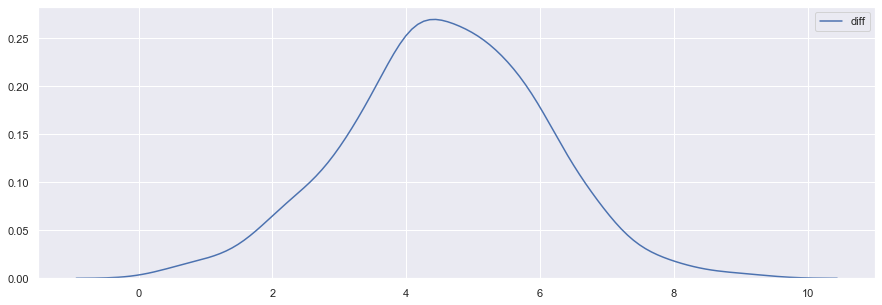

In [95]:
boot_7_day['diff']=(boot_7_day['gate_30']-boot_7_day['gate_40'])/boot_7_day['gate_40']*100

sns.kdeplot(boot_7_day['diff']);

__The difference in retention is most likely around 4%.__<br>
__Almost all of the distribution falls above 0% which clearly favours retention of gate at level 30.__
### __Thus, we conclude that 7 day retention is higher when the gate is placed at level 30__